In [1]:
import numpy as np 
import _pickle as cPickle
import gzip
import os
from sklearn.utils import shuffle
from tqdm import tqdm

In [3]:
# utility functions

def one_hot_encoded(y, num_class):
    n = y.shape[0]
    onehot = np.zeros((n, num_class), dtype="int32")
    for i in range(n):
        idx = y[i]
        onehot[i][idx] = 1
    return onehot


def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)  # both are not one hot encoded


def softmax(x):
    max_x = np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x - max_x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)
        
# l2 regularization
def l2_reg(layers, lam=0.001):
    reg_loss = 0.0
    for layer in layers:
        if hasattr(layer, 'W'):
            reg_loss += 0.5 * lam * np.sum(layer.W * layer.W)
    return reg_loss


# l2 regularization grad
def delta_l2_reg(layers, grads, lam=0.001):
    for layer, grad in zip(layers, reversed(grads)):
        if hasattr(layer, 'W'):
            grad[0] += lam * layer.W
    return grads


In [6]:
softmax(np.array([[1,2,3]]))

array([[0.09003057, 0.24472847, 0.66524096]])

In [7]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

In [8]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X, mode):
        self.X = X
        return np.maximum(X, 0)
    
    def backward(self, dout, mode):
        self.gradInput = dout.copy()
        self.gradInput[self.X <= 0] = 0
        return self.gradInput, []

In [9]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
relu = ReLU()
f = lambda x: relu.forward(x, mode='train').sum(axis=1).sum()
res = f(points)
numeric_grads = eval_numerical_gradient(f, points)
print(numeric_grads)
inp_grad = np.ones(shape=(10, 12))
grads = relu.backward(inp_grad, mode='train')[0]
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [10]:
class Linear():

    def __init__(self, in_size, out_size):

        # Xavier init
        self.W = np.random.randn(in_size, out_size) / np.sqrt(in_size + out_size/ 2.)
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, X, mode):
        self.X = X
        return X.dot(self.W) + self.b
    
    def backward(self, dout, mode):
        self.gradW = self.X.T.dot(dout)        
        self.gradInput = dout.dot(self.W.T)
        self.gradB = dout.sum(axis=0)
        return self.gradInput, [self.gradW, self.gradB]

In [11]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
relu = Linear(12, 5)
f = lambda x: relu.forward(x, mode='train').sum(axis=1).sum()
res = f(points)
numeric_grads = eval_numerical_gradient(f, points)
print(numeric_grads)
inp_grad = np.ones(shape=(10, 5))
grads = relu.backward(inp_grad, mode='train')[0]
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

[[-0.03683751  0.22613802  0.71336409  0.18683848  0.38311137  0.47141595
  -1.06829164 -0.2807766   0.3800087   0.12426938 -0.17073428 -0.24281456]
 [-0.03683751  0.22613802  0.71336409  0.18683848  0.38311137  0.47141595
  -1.06829164 -0.2807766   0.3800087   0.12426938 -0.17073428 -0.24281456]
 [-0.03683751  0.22613802  0.71336409  0.18683848  0.38311137  0.47141595
  -1.06829164 -0.2807766   0.3800087   0.12426938 -0.17073428 -0.24281456]
 [-0.03683751  0.22613802  0.71336409  0.18683848  0.38311137  0.47141595
  -1.06829164 -0.2807766   0.3800087   0.12426938 -0.17073428 -0.24281456]
 [-0.03683751  0.22613802  0.71336409  0.18683848  0.38311137  0.47141595
  -1.06829164 -0.2807766   0.3800087   0.12426938 -0.17073428 -0.24281456]
 [-0.03683751  0.22613802  0.71336409  0.18683848  0.38311137  0.47141595
  -1.06829164 -0.2807766   0.3800087   0.12426938 -0.17073428 -0.24281456]
 [-0.03683751  0.22613802  0.71336409  0.18683848  0.38311137  0.47141595
  -1.06829164 -0.2807766   0.380

In [12]:
class CrossEntropyLoss(object):

    def forward(self, X, y):
        self.m = y.shape[0] # self.m == X.shape[0], y.shape == (X.shape[0], )
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y])
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        dx = self.p.copy()
        dx[range(self.m), y] -= 1
        dx /= self.m
        return dx

## NN implementation

In [13]:
class NN:

    def __init__(self, loss_func=CrossEntropyLoss(), mode = 'train'):
    
        self.layers = []
        self.params = []
        self.loss_func = loss_func
        self.grads = []
        self.mode = mode

    def add_layer(self,layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X, self.mode)
        return X

    def backward(self, dout):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            dout, grad = layer.backward(dout, self.mode)
            self.grads.append(grad)
        return self.grads

    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        dout = self.loss_func.backward(out,y)
        loss += l2_reg(self.layers)
        grads = self.backward(dout)
        grads = delta_l2_reg(self.layers, grads)
        return loss, grads

    def predict(self, X):
        X = self.forward(X)
        return np.argmax(softmax(X), axis=1)


    def dispGradParam():
        print(self.grads)
    

    def clear_grad_param(self):
        self.grads = []

In [14]:
# SGD with momentum
def update(velocity, params, grads, learning_rate=0.001, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] + learning_rate * g[i]
            p[i] -= v[i]


# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    X, y = shuffle(X, y)

    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, ...]
        y_batch = y[i:i + minibatch_size, ...]

        minibatches.append((X_batch, y_batch))
    return minibatches


In [15]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9,
                 verbose=True, X_val=None, y_val=None, nesterov=True):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)

    c = 0 
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)

        if verbose:
            print("Epoch {0}".format(i + 1))

        # iterate over mini batches
        for X_mini, y_mini in tqdm(minibatches):

            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads,
                            learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in tqdm(minibatches_val):
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)


        # accuracy of model at end of epoch after all mini batch updates   

        if verbose:
            m_train = X_train.shape[0]
            m_val = X_val.shape[0]
            y_train_pred = np.array([], dtype="int64")
            y_val_pred = np.array([], dtype="int64")

            for i in range(0, m_train, minibatch_size):
                X_tr = X_train[i:i + minibatch_size, : ]
                y_tr = y_train[i:i + minibatch_size, ]
                y_train_pred = np.append(y_train_pred, net.predict(X_tr))

            for i in range(0, m_val, minibatch_size):
                X_va = X_val[i:i + minibatch_size, : ]
                y_va = y_val[i:i + minibatch_size, ]
                y_val_pred = np.append(y_val_pred, net.predict(X_va))

            train_acc = check_accuracy(y_train, y_train_pred)
            val_acc = check_accuracy(y_val, y_val_pred)

            mean_train_loss = sum(loss_batch) / float(len(loss_batch))
            mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))


            # early stopping with patience = 5 on val loss

            if len(val_loss_epoch) == 0:
                val_loss_epoch.append(mean_val_loss)
            else:
                for j in val_loss_epoch[-5:]:
                    if mean_val_loss > j:
                        c += 1
                    else:
                        c = 0
                if c > 5:
                    print('Early stopping')
                    return net
                else:
                    c = 0
                    val_loss_epoch.append(mean_val_loss)    


            print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(
                mean_train_loss, train_acc, mean_val_loss, val_acc))
    return net


In [16]:

# Get preprocessed training and validation data

X_train = np.array([
    [1, 2, 1, 2],
    [2, 4, 2, 4],
    [2, 1, 2, 1],
    [4, 2, 4, 2],
])

y_train = np.array([0, 1, 0, 1])
X_val = X_train.copy()
y_val = y_train.copy()

print(X_train.shape)
print(X_val.shape)


# define neural net
model = NN()

# add some layers
model.add_layer(Linear(X_train.shape[1], 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 2))

model = train(model, X_train , y_train, minibatch_size=4, epoch=100,
           learning_rate=0.1, X_val=X_val, y_val=y_val)




  0%|          | 0/1 [00:00<?, ?it/s]

(4, 4)
(4, 4)
Epoch 1
Loss = 0.687618483991582 | Training Accuracy = 0.5 | Val Loss = 0.6779384633133831 | Val Accuracy = 0.5
Epoch 2
Loss = 0.6779384633133831 | Training Accuracy = 0.5 | Val Loss = 0.6716663975688475 | Val Accuracy = 0.5
Epoch 3
Loss = 0.6716663975688475 | Training Accuracy = 0.5 | Val Loss = 0.6656490505156851 | Val Accuracy = 0.5
Epoch 4
Loss = 0.6656490505156851 | Training Accuracy = 0.5 | Val Loss = 0.6596978843054356 | Val Accuracy = 0.5
Epoch 5
Loss = 0.6596978843054356 | Training Accuracy = 0.5 | Val Loss = 0.6538589733858822 | Val Accuracy = 0.5
Epoch 6
Loss = 0.6538589733858822 | Training Accuracy = 0.5 | Val Loss = 0.6479875839773586 | Val Accuracy = 0.5
Epoch 7
Loss = 0.6479875839773586 | Training Accuracy = 0.5 | Val Loss = 0.6421428874880504 | Val Accuracy = 0.5
Epoch 8
Loss = 0.6421428874880504 | Training Accuracy = 0.5 | Val Loss = 0.6363124226956972 | Val Accuracy = 0.5
Epoch 9
Loss = 0.6363124226956972 | Training Accuracy = 0.5 | Val Loss = 0.63050934

100%|██████████| 1/1 [00:00<00:00, 880.79it/s]

Loss = 0.6247368869501292 | Training Accuracy = 0.5 | Val Loss = 0.6189859050725849 | Val Accuracy = 0.5
Epoch 12
Loss = 0.6189859050725849 | Training Accuracy = 0.5 | Val Loss = 0.613252277559553 | Val Accuracy = 0.5
Epoch 13
Loss = 0.613252277559553 | Training Accuracy = 0.5 | Val Loss = 0.6075325251219607 | Val Accuracy = 0.5
Epoch 14
Loss = 0.6075325251219607 | Training Accuracy = 0.5 | Val Loss = 0.6018235644664137 | Val Accuracy = 0.5
Epoch 15
Loss = 0.6018235644664137 | Training Accuracy = 0.5 | Val Loss = 0.5961226287093434 | Val Accuracy = 0.5
Epoch 16
Loss = 0.5961226287093434 | Training Accuracy = 0.5 | Val Loss = 0.5904272117688752 | Val Accuracy = 0.5
Epoch 17
Loss = 0.5904272117688752 | Training Accuracy = 0.5 | Val Loss = 0.5847350268351028 | Val Accuracy = 0.5
Epoch 18
Loss = 0.5847350268351028 | Training Accuracy = 0.5 | Val Loss = 0.5790439750660844 | Val Accuracy = 0.5
Epoch 19
Loss = 0.5790439750660844 | Training Accuracy = 0.5 | Val Loss = 0.5733521219099568 | Val 


100%|██████████| 1/1 [00:00<00:00, 1125.99it/s]

Loss = 0.5160691927969426 | Training Accuracy = 1.0 | Val Loss = 0.5102896396035372 | Val Accuracy = 1.0
Epoch 31
Loss = 0.5102896396035372 | Training Accuracy = 1.0 | Val Loss = 0.5044720710883019 | Val Accuracy = 1.0
Epoch 32
Loss = 0.5044720710883019 | Training Accuracy = 1.0 | Val Loss = 0.49864795665436834 | Val Accuracy = 1.0
Epoch 33
Loss = 0.49864795665436834 | Training Accuracy = 1.0 | Val Loss = 0.49281624004077945 | Val Accuracy = 1.0
Epoch 34
Loss = 0.49281624004077945 | Training Accuracy = 1.0 | Val Loss = 0.48698587175706004 | Val Accuracy = 1.0
Epoch 35
Loss = 0.48698587175706004 | Training Accuracy = 1.0 | Val Loss = 0.48109608484157246 | Val Accuracy = 1.0
Epoch 36
Loss = 0.48109608484157246 | Training Accuracy = 1.0 | Val Loss = 0.47516936631001594 | Val Accuracy = 1.0
Epoch 37
Loss = 0.47516936631001594 | Training Accuracy = 1.0 | Val Loss = 0.4688816071813823 | Val Accuracy = 1.0
Epoch 38
Loss = 0.4688816071813823 | Training Accuracy = 1.0 | Val Loss = 0.46273942079


  0%|          | 0/1 [00:00<?, ?it/s]

Loss = 0.3810174561243225 | Training Accuracy = 1.0 | Val Loss = 0.3747515588874246 | Val Accuracy = 1.0
Epoch 53
Loss = 0.3747515588874246 | Training Accuracy = 1.0 | Val Loss = 0.36844857777445944 | Val Accuracy = 1.0
Epoch 54
Loss = 0.36844857777445944 | Training Accuracy = 1.0 | Val Loss = 0.362234776132652 | Val Accuracy = 1.0
Epoch 55
Loss = 0.362234776132652 | Training Accuracy = 1.0 | Val Loss = 0.3560416585677346 | Val Accuracy = 1.0
Epoch 56
Loss = 0.3560416585677346 | Training Accuracy = 1.0 | Val Loss = 0.34986592906218955 | Val Accuracy = 1.0
Epoch 57
Loss = 0.34986592906218955 | Training Accuracy = 1.0 | Val Loss = 0.3437106862803615 | Val Accuracy = 1.0
Epoch 58
Loss = 0.3437106862803615 | Training Accuracy = 1.0 | Val Loss = 0.3376353586502209 | Val Accuracy = 1.0
Epoch 59
Loss = 0.3376353586502209 | Training Accuracy = 1.0 | Val Loss = 0.33176696934203975 | Val Accuracy = 1.0
Epoch 60
Loss = 0.33176696934203975 | Training Accuracy = 1.0 | Val Loss = 0.32576988188480566

  0%|          | 0/1 [00:00<?, ?it/s]

Loss = 0.2790391972950644 | Training Accuracy = 1.0 | Val Loss = 0.2734500001409982 | Val Accuracy = 1.0
Epoch 70
Loss = 0.2734500001409982 | Training Accuracy = 1.0 | Val Loss = 0.2681225153107171 | Val Accuracy = 1.0
Epoch 71
Loss = 0.2681225153107171 | Training Accuracy = 1.0 | Val Loss = 0.2627886885280921 | Val Accuracy = 1.0
Epoch 72
Loss = 0.2627886885280921 | Training Accuracy = 1.0 | Val Loss = 0.2573719753546556 | Val Accuracy = 1.0
Epoch 73
Loss = 0.2573719753546556 | Training Accuracy = 1.0 | Val Loss = 0.2522569218702651 | Val Accuracy = 1.0
Epoch 74
Loss = 0.2522569218702651 | Training Accuracy = 1.0 | Val Loss = 0.2468736910423922 | Val Accuracy = 1.0
Epoch 75
Loss = 0.2468736910423922 | Training Accuracy = 1.0 | Val Loss = 0.24184070941642344 | Val Accuracy = 1.0
Epoch 76
Loss = 0.24184070941642344 | Training Accuracy = 1.0 | Val Loss = 0.23669172466122884 | Val Accuracy = 1.0
Epoch 77
Loss = 0.23669172466122884 | Training Accuracy = 1.0 | Val Loss = 0.23177482291420184

100%|██████████| 1/1 [00:00<00:00, 1248.30it/s]

Loss = 0.1928221678808272 | Training Accuracy = 1.0 | Val Loss = 0.19123299707082542 | Val Accuracy = 1.0
Epoch 88
Loss = 0.19123299707082542 | Training Accuracy = 1.0 | Val Loss = 0.1866878268951916 | Val Accuracy = 1.0
Epoch 89
Loss = 0.1866878268951916 | Training Accuracy = 1.0 | Val Loss = 0.18603958041881366 | Val Accuracy = 1.0
Epoch 90
Loss = 0.18603958041881366 | Training Accuracy = 1.0 | Val Loss = 0.18070855698052302 | Val Accuracy = 1.0
Epoch 91
Loss = 0.18070855698052302 | Training Accuracy = 1.0 | Val Loss = 0.18284538611950904 | Val Accuracy = 1.0
Epoch 92
Loss = 0.18284538611950904 | Training Accuracy = 1.0 | Val Loss = 0.17609678295713777 | Val Accuracy = 1.0
Epoch 93
Loss = 0.17609678295713777 | Training Accuracy = 1.0 | Val Loss = 0.181091805237042 | Val Accuracy = 1.0
Epoch 94
Loss = 0.181091805237042 | Training Accuracy = 1.0 | Val Loss = 0.1707060454863957 | Val Accuracy = 1.0
Epoch 95
Loss = 0.1707060454863957 | Training Accuracy = 1.0 | Val Loss = 0.1754271344348

## Mnist training

In [17]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [18]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [19]:
y = y.astype(np.int32)
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.25,
                                                  shuffle=True,
                                                  random_state=0)


In [20]:
import matplotlib.pyplot as plt
%matplotlib notebook

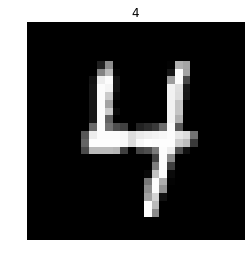

In [21]:
# visualize data

def vis(img, label):
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')
    plt.show()

vis_idx = 1
vis(X_val[vis_idx].reshape(-1, 28), y_val[vis_idx])

In [22]:
print(X_train.shape)
print(X_val.shape)


# define neural net
model = NN()

# add some layers
model.add_layer(Linear(X.shape[1], 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 10))


model = train(model, X_train , y_train, minibatch_size=128, epoch=10,
           learning_rate=0.001, X_val=X_val, y_val=y_val)




(52500, 784)
(17500, 784)


  5%|▍         | 19/411 [00:00<00:02, 187.50it/s]

Epoch 1


  3%|▎         | 12/411 [00:00<00:03, 115.07it/s]

Loss = 1.1998314458187358 | Training Accuracy = 0.8976 | Val Loss = 0.18645351786898343 | Val Accuracy = 0.8888
Epoch 2


  4%|▎         | 15/411 [00:00<00:02, 148.29it/s]

Loss = 0.366326231954017 | Training Accuracy = 0.9352761904761905 | Val Loss = 0.11366650330198699 | Val Accuracy = 0.9238285714285714
Epoch 3


  4%|▍         | 16/411 [00:00<00:02, 150.66it/s]

Loss = 0.3106675162406056 | Training Accuracy = 0.9449142857142857 | Val Loss = 0.10049779437928447 | Val Accuracy = 0.9316571428571429
Epoch 4


  3%|▎         | 12/411 [00:00<00:03, 119.45it/s]

Loss = 0.2817044622839786 | Training Accuracy = 0.9472 | Val Loss = 0.10024133917260326 | Val Accuracy = 0.9339428571428572
Epoch 5


  4%|▍         | 16/411 [00:00<00:02, 155.63it/s]

Loss = 0.2606372657095778 | Training Accuracy = 0.9505142857142858 | Val Loss = 0.09820740052184003 | Val Accuracy = 0.9364
Epoch 6


  3%|▎         | 14/411 [00:00<00:02, 136.66it/s]

Loss = 0.2451825155835454 | Training Accuracy = 0.9526476190476191 | Val Loss = 0.09841648591580933 | Val Accuracy = 0.9373142857142858
Epoch 7


  3%|▎         | 11/411 [00:00<00:03, 101.99it/s]

Loss = 0.23398151014339966 | Training Accuracy = 0.9544190476190476 | Val Loss = 0.1004596801753301 | Val Accuracy = 0.9374857142857143
Epoch 8


  2%|▏         | 9/411 [00:00<00:05, 78.63it/s]

Loss = 0.22485948845046141 | Training Accuracy = 0.9566095238095238 | Val Loss = 0.09887217416058118 | Val Accuracy = 0.9405714285714286
Epoch 9


  1%|▏         | 6/411 [00:00<00:07, 55.53it/s]

Loss = 0.2169012439418813 | Training Accuracy = 0.9589333333333333 | Val Loss = 0.09520575661378539 | Val Accuracy = 0.9420571428571428
Epoch 10


100%|██████████| 137/137 [00:00<00:00, 324.65it/s]


Loss = 0.2106751938478122 | Training Accuracy = 0.9588571428571429 | Val Loss = 0.09428998855873569 | Val Accuracy = 0.9426285714285715


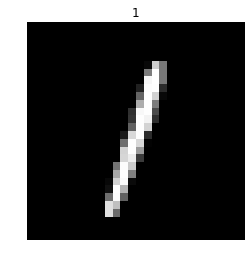

In [23]:
# visualize prediction 

vis_idx = 1000

pred = model.predict(X_val[vis_idx])
vis(X_val[vis_idx].reshape(-1, 28), pred[0])

# TODO:
1) Add computational graph instead of list, model saving/loading, more optimizers, shedulers, loss functions, operations, gpu support, utility tools ...

... Or simply use Pytorch/TF/whatever